In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [9]:
inspector=inspect(engine)
columns=inspector.get_columns("measurement")
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector=inspect(engine)
columns=inspector.get_columns("station")
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
mostrecentdate=dt.datetime.strptime((session.query(measurement.date).order_by(measurement.date.desc()).\
                                     first())[0],'%Y-%m-%d').date()
print(f"the most recent date in the data set is {mostrecentdate}")

the most recent date in the data set is 2017-08-23


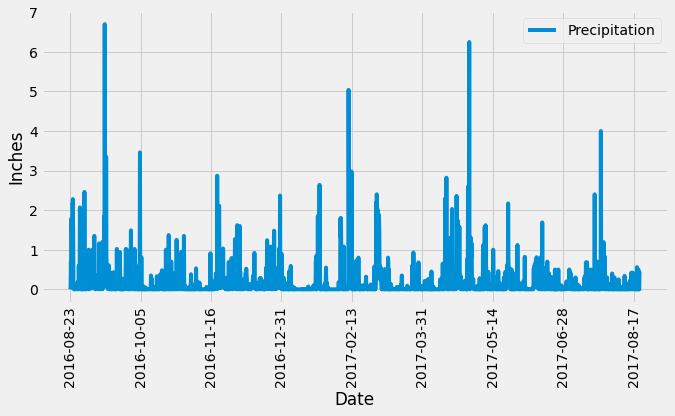

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twelvemonthsago = mostrecentdate-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
oneyearago=session.query(measurement.date,measurement.prcp).\
filter(measurement.date >=(mostrecentdate-dt.timedelta(days=365))).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_lastyear = pd.DataFrame(oneyearago, columns=['Date','Precipitation']).dropna(how='any').set_index("Date")
# Sort the dataframe by date
precip_lastyear = precip_lastyear.sort_values(["Date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_lastyear.plot(rot=90,figsize=(10,5))
plt.ylabel("Inches")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_lastyear.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(station.station).distinct().count()
print(f" the total number stations in the dataset is {total_stations}")

 the total number stations in the dataset is 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
active_station=session.query(measurement.station,func.count(measurement.id)).\
group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
# List the stations and the counts in descending order
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactive=session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station==active_station[0][0]).all()

print(F'''the most active station id is: {active_station[0][0]} 
     TEMPERATURE STATS:
     -----------------------------------------
     lowest temperature: {mostactive[0][1]} 
     highest temperature: {mostactive[0][2]} 
     average temperature: {mostactive[0][3]}''')

the most active station id is: USC00519281 
     TEMPERATURE STATS:
     -----------------------------------------
     lowest temperature: 54.0 
     highest temperature: 85.0 
     average temperature: 71.66378066378067


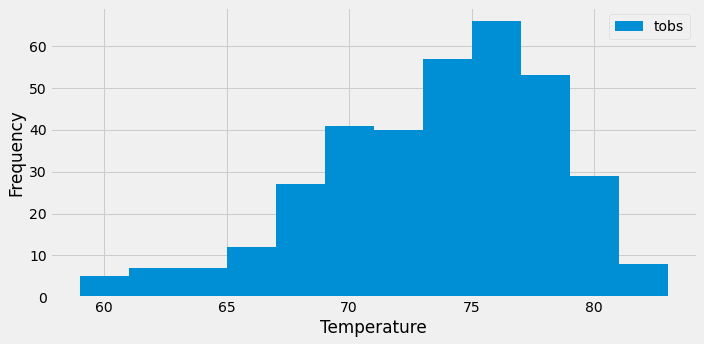

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive_lastyear=pd.DataFrame(session.query(measurement.tobs).\
filter(measurement.date >=(mostrecentdate-dt.timedelta(days=365))).\
filter(measurement.station==active_station[0][0]).all())
plt.figure(figsize=(10,5))
plt.hist(mostactive_lastyear, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Close session

In [39]:
# Close Session
session.close()